<a href="https://colab.research.google.com/github/hanhanwu/Hanhan_LangGraph_Exercise/blob/main/RAG_Chatbot/try_corrective_rag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture --no-stderr
%pip install -U --quiet langchain-community tiktoken langchain-openai langchainhub chromadb langchain langgraph langchain-text-splitters playwright unstructured tavily-python
!playwright install
%pip install -U --quiet rank_bm25 faiss-cpu

In [7]:
from google.colab import userdata
import os

def _set_env(key_name: str, key_value: str):
    if key_name not in os.environ:
      os.environ[key_name] = key_value

# load the environment variables set in colab
_set_env('OPENAI_API_KEY', userdata.get('OPENAI_API_KEY'))
_set_env('LANGSMITH_API_KEY', userdata.get('LANGSMITH_API_KEY'))
_set_env('TAVILY_API_KEY', userdata.get('TAVILY_API_KEY'))  # TAVILY_API_KEY has to be environment variable....

## Retriever

In [8]:
from langchain_community.document_loaders import PlaywrightURLLoader
from langchain_community.vectorstores import Chroma
from langchain.retrievers import EnsembleRetriever
from langchain_community.retrievers import BM25Retriever
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.tools.retriever import create_retriever_tool


urls = [
   "https://www.ana.co.jp/en/us/travel-information/customers-with-disabilities/walking-disabilities/",
   "https://www.ana.co.jp/en/us/travel-information/customers-with-disabilities/visual-disabilities/",
]

loader = PlaywrightURLLoader(urls=urls, remove_selectors=["header", "footer"])
docs = await loader.aload()  # returns "Document" type

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=200, chunk_overlap=80
)
doc_splits = text_splitter.split_documents(docs)  # split into chunks with overlap

# choose retriever type based on the number of chunks
chunks_ct = len(doc_splits)
if chunks_ct < 30:
  print(chunks_ct, 'choose vectorstore based retriever')
  # use Vectorstore-backed retriever (the simplest retriever in LangChain)
  vectorstore = Chroma.from_documents(
      documents=doc_splits,
      collection_name="rag-chroma",
      embedding=OpenAIEmbeddings(),  # OPENAI_API_KEY is env variable, no need to be specified here
  )
  retriever = vectorstore.as_retriever()
else:
  print(chunks_ct, 'choose ensemble retriever')
  # use emsemble retriever
  # initialize the bm25 retriever and faiss retriever
  bm25_retriever = BM25Retriever.from_texts(
      [doc.page_content for doc in doc_splits], metadatas=[{"source": 1}] * len(doc_splits)
  )
  bm25_retriever.k = 2
  embedding = OpenAIEmbeddings()
  faiss_vectorstore = FAISS.from_texts(
      [doc.page_content for doc in doc_splits], embedding, metadatas=[{"source": 2}] * len(doc_splits)
  )
  faiss_retriever = faiss_vectorstore.as_retriever(search_kwargs={"k": 2})
  # initialize the ensemble retriever
  retriever = EnsembleRetriever(
      retrievers=[bm25_retriever, faiss_retriever], weights=[0.5, 0.5]
  )

44 choose ensemble retriever


## State of Graph

In [27]:
from typing import List
from typing_extensions import TypedDict


class GraphState(TypedDict):
    question: str
    generated_answer: str
    needs_web_search: str  # "yes" or "no" decides whether needs web search
    docs: List[str]

## Nodes & Edges

* When all the retrieved documents are relevant, generate the answer directly
* Otherwise, question will be updated to search from the web, searched document will be added to relevant documents, and all the docuemnts will be used to generate the answer

In [28]:
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

from langchain import hub
from langchain_core.messages import HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI
from langchain.schema import Document
from langchain_community.tools.tavily_search import TavilySearchResults


model_str = "gpt-4o-mini-2024-07-18"
web_search_tool = TavilySearchResults(k=3)  # return 3 search results

#### nodes

In [48]:
def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state
    Returns:
        state (dict): retrieved documents added to the graph state; question stays the same
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"docs": documents, "question": question}


def grade_documents(state):
    """
    Check each retrieved document, if there is any un-relevant document, set "needs_web_search" as "yes".
    All the relevant documents will be saved too.

    Args:
        state (dict): The current state
    Returns:
        state (dict): retrieved relevant documents; the decison on "needs_web_search"; question stays the same
    """
    print("---CHECK RELEVANCE---")

    # Data model
    class grade(BaseModel):
        """Binary score for relevance check."""
        binary_score: str = Field(description="Relevance score 'yes' or 'no'")

    # LLM
    model = ChatOpenAI(temperature=0,
                       model=model_str, streaming=True)
    # LLM with tool and validation
    llm_with_tool = model.with_structured_output(grade)

    # Prompt
    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )

    # Relevancy Grader
    grader = prompt | llm_with_tool

    question = state['question']
    retrieved_docs = state['docs']

    relevant_docs = []
    needs_web_search = 'no'
    for doc in retrieved_docs:
      scored_result = grader.invoke({'question': question, 'context': doc.page_content})
      score = scored_result.binary_score

      if score == 'yes':
          relevant_docs.append(doc)
      else:
          needs_web_search = 'yes'

    print(f"---% OF RELEVANT DOCS: {len(relevant_docs) * 100 / len(retrieved_docs)}---")
    return {'docs': relevant_docs,
            'question': question,
            'needs_web_search': needs_web_search}


def rewrite_query(state):
    """
    Transform the query to produce a better query.

    Args:
        state (dict): The current state
    Returns:
        dict: The updated state with re-phrased query
    """
    print("---REWRITE QUERY---")
    question = state['question']

    msg = [
        HumanMessage(
            content=f""" \n
                    Look at the input and try to reason about the underlying semantic intent or meaning. \n
                    Here is the initial question:
                    \n ------- \n
                    {question}
                    \n ------- \n
                    Formulate an improved question: """,
        )
    ]

    # Grader
    model = ChatOpenAI(temperature=0,
                       model=model_str, streaming=True)
    updated_query = model.invoke(msg)
    return {'question': updated_query.content}


def search_web(state):
  """
  Search web with updated query, add searched answers into docs.

  Args:
      state (dict): The current state
  Returns:
      dict: The updated state with searched answers
  """
  print("---SEARCH WEB---")
  question = state['question']
  docs = state['docs']
  searched_docs = web_search_tool.invoke({'query': question})
  web_results = '\n'.join([d['content'] for d in searched_docs])
  web_results = Document(page_content=web_results)
  docs.append(web_results)
  return {'docs': docs}


def generate_answer(state):
    """
    Generate answer

    Args:
        state (dict): The current state
    Returns:
         dict: The updated state with generated answer
    """
    print("---GENERATE ANSWER---")
    question = state['question']
    docs = state['docs']

    # Prompt
    prompt = hub.pull("rlm/rag-prompt")

    # LLM
    llm = ChatOpenAI(model_name=model_str,
                     temperature=0, streaming=True)

    # Chain
    rag_chain = prompt | llm | StrOutputParser()

    # Run
    response = rag_chain.invoke({"context": docs, "question": question})
    return {"generated_answer": response, 'question': question}


#### conditional edges

In [49]:
def decide_answer_generation(state):
  """
  Based on the value of "needs_web_search" from grade_documents, decide to go to generate_answer node or rewrite_query node.

  Args:
      state (dict): The current state
  Returns:
      str: The decision node name
  """
  needs_web_search = state['needs_web_search']

  if needs_web_search == 'yes':
    print('---DECIDE TO REWRITE QUERY---')
    return 'rewrite_query'
  else:
    print('---DECIDE TO GENERATE ANSWER---')
    return 'generate_answer'

## Build Graph

In [50]:
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode

# Define a new graph
workflow = StateGraph(GraphState)

# Define the nodes we will cycle between
workflow.add_node("retrieve", retrieve)
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("rewrite_query", rewrite_query)
workflow.add_node("search_web", search_web)
workflow.add_node("generate_answer", generate_answer)

workflow.add_edge(START, 'retrieve')
workflow.add_edge('retrieve', 'grade_documents')
workflow.add_conditional_edges(
    'grade_documents',
    decide_answer_generation,
    {
        'rewrite_query': 'rewrite_query',
        'generate_answer': 'generate_answer'
    },
)
workflow.add_edge("rewrite_query", "search_web")
workflow.add_edge("search_web", "generate_answer")
workflow.add_edge("generate_answer", END)

# Compile
graph = workflow.compile()

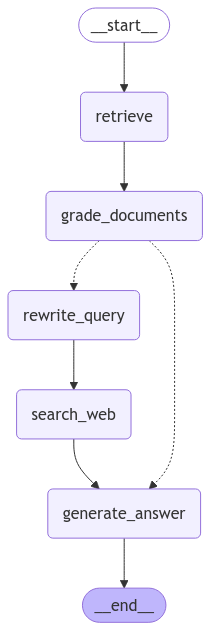

In [51]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## Build Corrective RAG

In [56]:
import pprint
from langchain_core.runnables import RunnableConfig
from langgraph.errors import GraphRecursionError


def run_graph(inputs):
  graph_config = RunnableConfig(recursion_limit=10)  # Increase if necessary
  try:
    output = list(graph.stream(inputs, config=graph_config))[-1] # Get the last element from the stream
    pprint.pprint(output.get('generate_answer', "Answer not found.")) # Use get to avoid KeyError and provide default message

  except GraphRecursionError as e:
    print()
    print("Can't find relevant answer")

In [57]:
inputs = {'question': 'What are the battery types?'}
run_graph(inputs)

---RETRIEVE---
---CHECK RELEVANCE---
---% OF RELEVANT DOCS: 50.0---
---DECIDE TO REWRITE QUERY---
---REWRITE QUERY---
---SEARCH WEB---
---GENERATE ANSWER---
{'generated_answer': 'Different types of batteries include lithium-ion, '
                     'nickel-cadmium (NiCd), nickel-metal hydride (NiMH), '
                     'lead-acid, and alkaline batteries. Lithium-ion batteries '
                     'are commonly used in portable electronics like '
                     'smartphones and laptops due to their high energy '
                     'density, while lead-acid batteries are typically found '
                     'in vehicles and backup power systems. Alkaline batteries '
                     'are often used in low-drain devices such as remote '
                     'controls and clocks.',
 'question': 'What are the different types of batteries and their specific '
             'applications?'}


In [59]:
inputs = {'question': 'Who is Hanhan Wu?'}
run_graph(inputs)

---RETRIEVE---
---CHECK RELEVANCE---
---% OF RELEVANT DOCS: 0.0---
---DECIDE TO REWRITE QUERY---
---REWRITE QUERY---
---SEARCH WEB---
---GENERATE ANSWER---
{'generated_answer': 'Hanhan Wu, also known as Emperor Wu of Han or Liu Che, '
                     'was a significant ruler of the Han Dynasty, reigning '
                     'from 141 BC to 87 BC. He is noted for expanding the '
                     'empire, establishing Confucianism as the state '
                     'philosophy, and setting up Confucian academies. His '
                     '54-year rule is marked by numerous achievements that had '
                     'a lasting impact on Chinese history.',
 'question': 'What are the notable achievements and background of Hanhan Wu?'}
